# MNIST データカバレッジ


In [1]:
!apt-get update -y 
!apt-get install -y libgl1-mesa-dev
# !apt-get install -y libglib2.0-0 libsm6 libxrender1 libxext6

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [1429 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates/multiverse amd64 Packages [27.7 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [1385 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Get:8 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [901 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates/restricted amd64 Packages [132 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [10.1 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [1089 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [116 kB]
Fe

In [2]:
!pip install sklearn
!pip install numpy
!pip install seaborn
!pip install opencv-python

     |████████████████████████████████| 6.8 MB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 300 kB 9.5 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=6141762b91af7844f2be9d167b446ad4e6374cb9a7781fb2e56f7a3f0bf48745
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 283 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 10.5 MB 11.7 MB/s eta 0:00:01   |██▋                             | 849 kB 4.7 MB/s eta 0:00:03     |████████████████████████▌       | 8.0 MB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 12.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/

In [3]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def load_mnist(path, kind='train'):

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [5]:
# load data

X_target, y_target = load_mnist('../data/Fashion-MNIST', kind='train')

# 前処理として、画像を最大値255で割って0.0 - 1.0に規格化する。
X_target_n = X_target / 255

print(type(X_target))
print(X_target.shape)

<class 'numpy.ndarray'>
(60000, 784)


In [6]:
classes = np.unique(y_target)
target_indexes={}

# クラス分類
for c in classes:
    target_indexes[c] = np.where(y_target == c)[0]

In [7]:
# mnist各クラス、各画像ごとの輪郭面積、重心、周囲長、最小外接円を算出

import cv2
import pandas as pd

moment_df = pd.DataFrame(columns=['ClassNo','ImageIndex','AreaID','Area','Rect-X','Rect-Y','Rect-W','Rect-H','Center-X','Center-Y','ArcLength', 'Radius'] )
# moment_df = pd.DataFrame(columns=['ClassNo','ImageIndex','AreaID','Area','Rect-X','Rect-Y','Rect-W','Rect-H','Center-X','Center-Y','ArcLength', 'Radius', 'Angle', 'Mean'] )

def calc_moment_image(class_no, df):

    for image_index in target_indexes[class_no]:
        _,thresh = cv2.threshold(X_target[image_index].reshape(28,28), 0, 255, cv2.THRESH_BINARY)

        # 輪郭の検出
        contours, _ = cv2.findContours(thresh , cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
        # 最大の輪郭面積を取得
        max_area = 0
        max_area_index = 0
        for i in range(len(contours)):
            area = cv2.contourArea(contours[i])
            if area > max_area:
                max_area = area
                max_area_index = i
            
        # 矩形領域
        x, y, w, h = cv2.boundingRect(contours[max_area_index])

        # 重心
        m = cv2.moments(contours[max_area_index])
        cx = int(m['m10']/m['m00'])
        cy = int(m['m01']/m['m00'])

        # 周囲長
        arc_length = cv2.arcLength(contours[max_area_index],True)
        
        # 最小外接円
        _,radius = cv2.minEnclosingCircle(contours[max_area_index])
        radius = int(radius)

#         # 傾き
#         _,_,angle = cv2.fitEllipse(contours[max_area_index])
        
#         # 画素平均
#         mean_val = cv2.mean(thresh)

#         se = pd.Series([class_no, image_index, max_area_index, max_area, x, y, w, h, cx, cy, arc_length, radius, angle, mean_val], index=df.columns )
        se = pd.Series([class_no, image_index, max_area_index, max_area, x, y, w, h, cx, cy, arc_length, radius], index=df.columns )
        df = df.append(se, ignore_index=True )

    return df
        
for c in classes:
    moment_df = calc_moment_image(c, moment_df)
moment_df.to_csv("moment.csv")

In [8]:
def calc_cov(target_moment_df, col_name, title, file_name, max_range ,interval=100):

    area_count_df = pd.DataFrame(columns=['StartRange','StopRange','Count'])

    for r in range(0, max_range, interval):
        range_ = r+interval
        cond_df = ((target_moment_df[col_name]>=r) & (target_moment_df[col_name]<range_))

        se = pd.Series([r, range_, cond_df.sum()], index=area_count_df.columns )
        area_count_df = area_count_df.append(se, ignore_index=True )

    min_ = target_moment_df[col_name].min()
    max_ = target_moment_df[col_name].max()

    target_calc_df = area_count_df.query('Count > 0')
    low = target_calc_df['StartRange'].min()
    high = target_calc_df['StopRange'].max()

    cov = (max_ - min_) / (high - low)
    
    sns_plt = sns.displot(data=target_moment_df, x=col_name)
    plt.title(title)
    sns_plt.savefig(file_name)

    return cov

total cov:0.88625


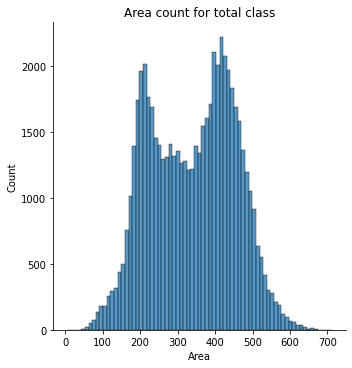

In [9]:
# トータルの輪郭面積カバレッジ
interval = 100
max_range = (28*28) + (interval-(28*28)%interval)
cov = calc_cov(moment_df, col_name='Area', title='Area count for total class', file_name='AreaCountTotalClass.png', max_range=max_range, interval=interval)
print(f'total cov:{cov}')

class:0 cov:0.7835714285714286
class:1 cov:0.8375
class:2 cov:0.88
class:3 cov:0.824375
class:4 cov:0.83
class:5 cov:0.9021428571428571
class:6 cov:0.8541666666666666
class:7 cov:0.9175
class:8 cov:0.8707142857142857
class:9 cov:0.7791666666666667


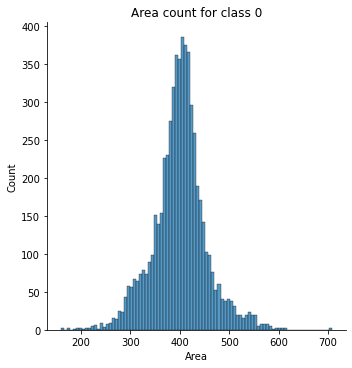

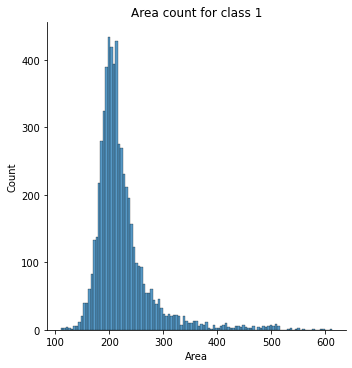

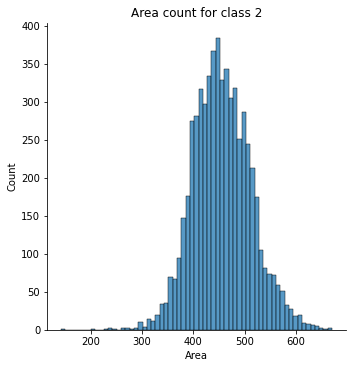

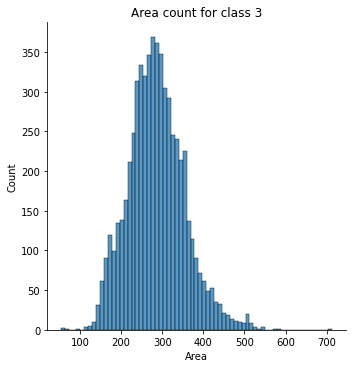

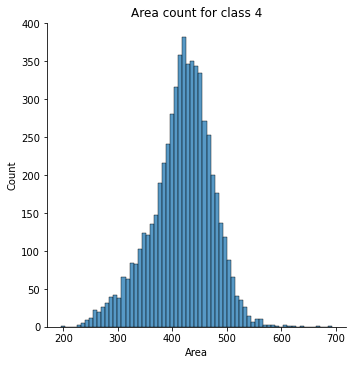

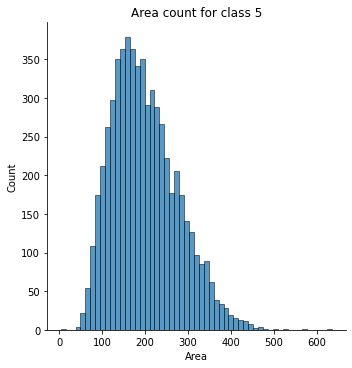

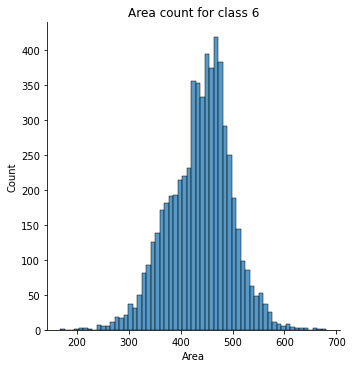

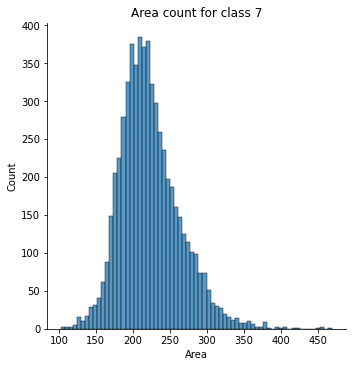

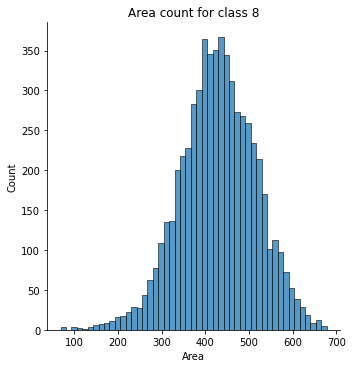

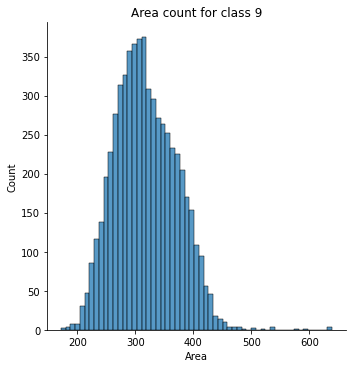

In [10]:
# クラス別の輪郭面積カバレッジ
interval = 100
max_range = (28*28) + (interval-(28*28)%interval)
for c in classes:
    cov = calc_cov(moment_df.query(f'ClassNo == {c}'), col_name='Area', title=f'Area count for class {c}', file_name=f'AreaCountClass{c}.png', max_range=max_range, interval=interval)
    print(f'class:{c} cov:{cov}')

total cov:0.8238055602196724


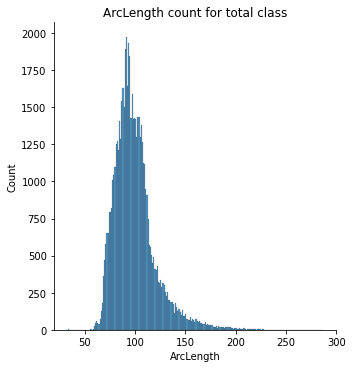

In [11]:
# トータルの輪郭周囲長カバレッジ
interval = 62
max_range = 620 # ≒ 1辺28px × 4
cov = calc_cov(moment_df, col_name='ArcLength', title='ArcLength count for total class', file_name='ArcLengthCountTotalClass.png', max_range=max_range, interval=interval)
print(f'total cov:{cov}')

class:0 cov:0.7506714540143167
class:1 cov:0.6965395103218734
class:2 cov:0.7271765226958901
class:3 cov:0.6260275533122401
class:4 cov:0.7125102762253054
class:5 cov:0.7433896495449928
class:6 cov:0.7332514838505817
class:7 cov:0.7764860545435259
class:8 cov:0.7158834838098095
class:9 cov:0.706751847779879


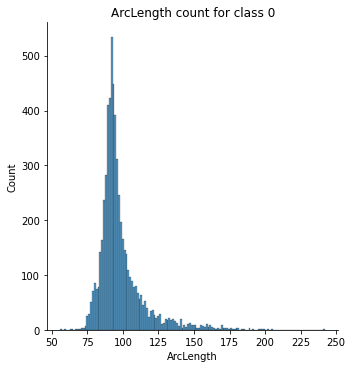

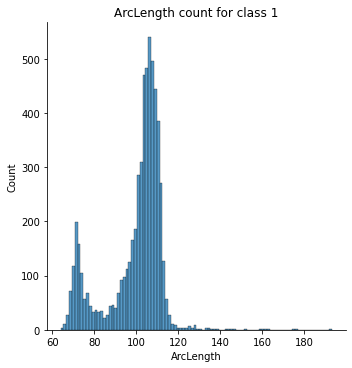

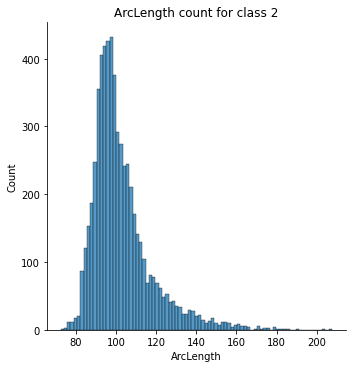

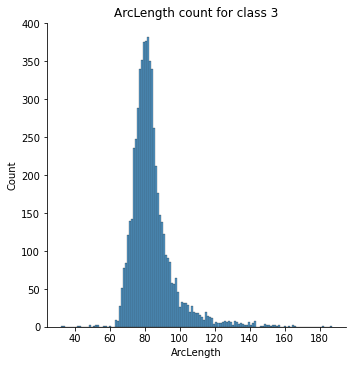

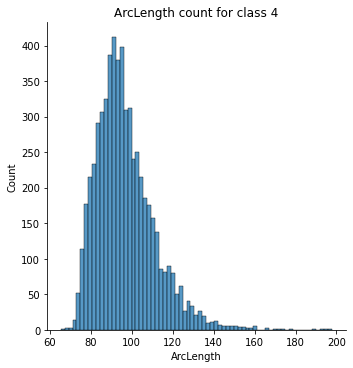

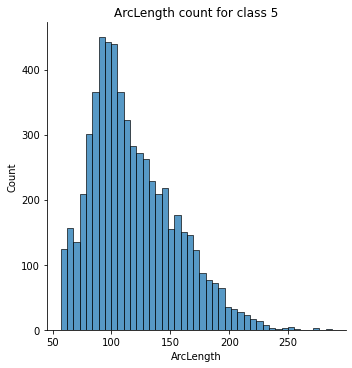

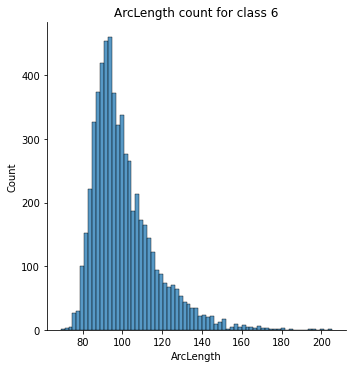

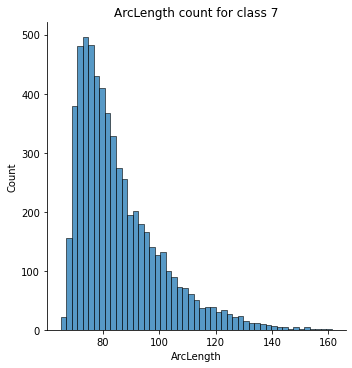

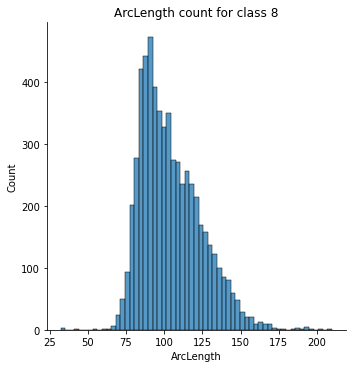

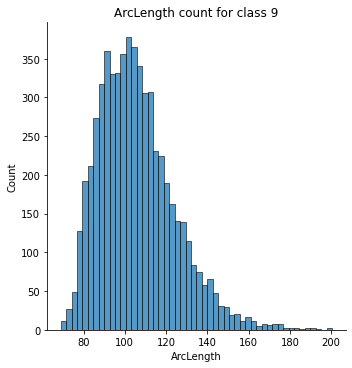

In [12]:
# クラス別の輪郭周囲長カバレッジ
interval = 62
max_range = 620 # ≒ 1辺28px × 4
for c in classes:
    cov = calc_cov(moment_df.query(f'ClassNo == {c}'), col_name='ArcLength', title=f'ArcLength count for class {c}', file_name=f'ArcLengthCountClass{c}.png', max_range=max_range, interval=interval)
    print(f'class:{c} cov:{cov}')

total cov:0.65


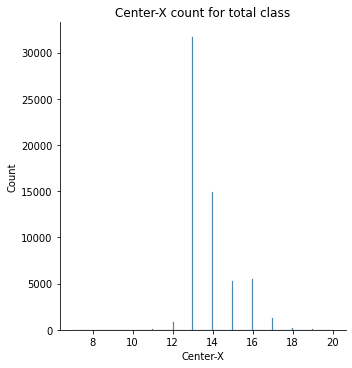

In [13]:
# トータルの輪郭重心(X)カバレッジ
interval = 4
max_range = 28
cov = calc_cov(moment_df, col_name='Center-X', title='Center-X count for total class', file_name='CenterXCountTotalClass.png', max_range=max_range, interval=interval)
print(f'total cov:{cov}')

class:0 cov:0.5
class:1 cov:0.5
class:2 cov:0.5
class:3 cov:0.375
class:4 cov:0.625
class:5 cov:0.6875
class:6 cov:0.5
class:7 cov:0.5
class:8 cov:0.5625
class:9 cov:0.75


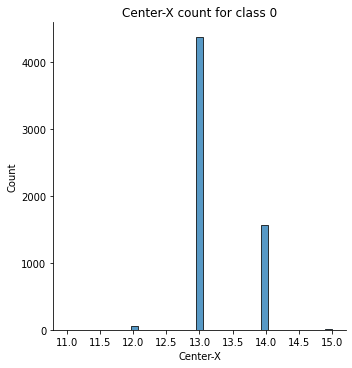

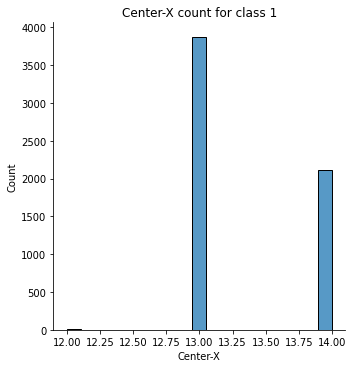

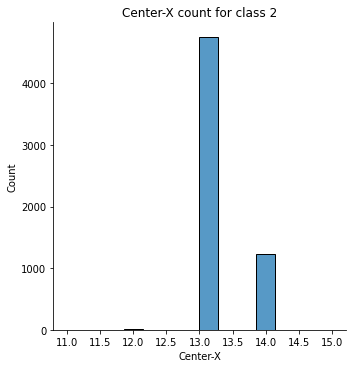

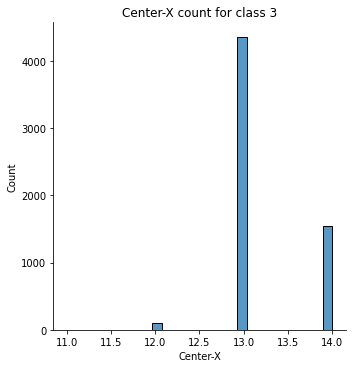

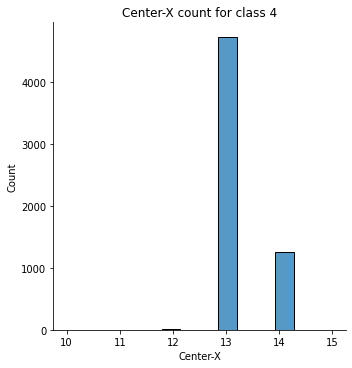

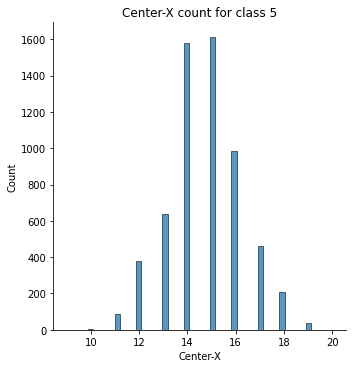

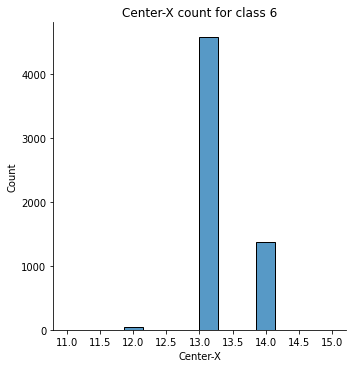

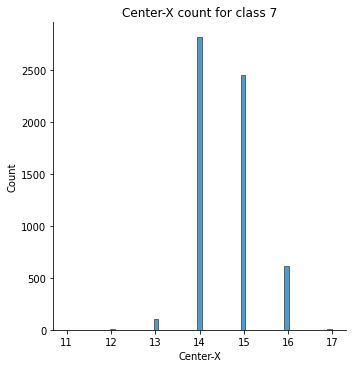

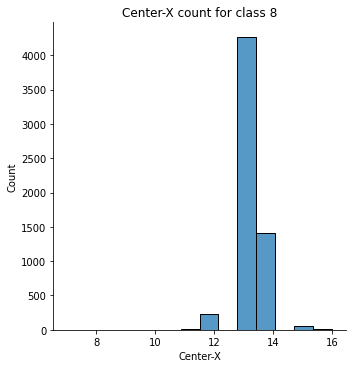

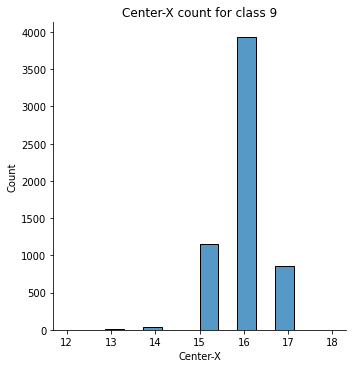

In [14]:
# クラス別の輪郭重心(X)カバレッジ
interval = 4
max_range = 28
for c in classes:
    cov = calc_cov(moment_df.query(f'ClassNo == {c}'), col_name='Center-X', title=f'Center-X count for class {c}', file_name=f'CenterXCountClass{c}.png', max_range=max_range, interval=interval)
    print(f'class:{c} cov:{cov}')

total cov:0.95


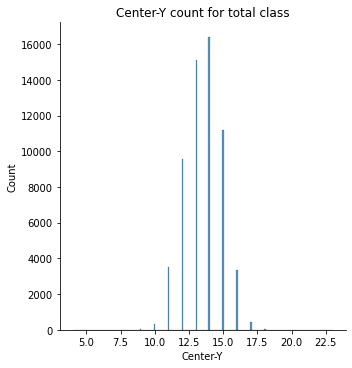

In [15]:
# トータルの輪郭重心(Y)カバレッジ
interval = 4
max_range = 28
cov = calc_cov(moment_df, col_name='Center-Y', title='Center-Y count for total class', file_name='CenterYCountTotalClass.png', max_range=max_range, interval=interval)
print(f'total cov:{cov}')

class:0 cov:0.9375
class:1 cov:0.5
class:2 cov:0.75
class:3 cov:0.9375
class:4 cov:0.5
class:5 cov:0.5833333333333334
class:6 cov:0.5833333333333334
class:7 cov:0.9166666666666666
class:8 cov:0.8
class:9 cov:0.75


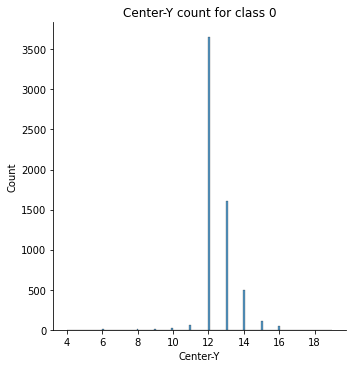

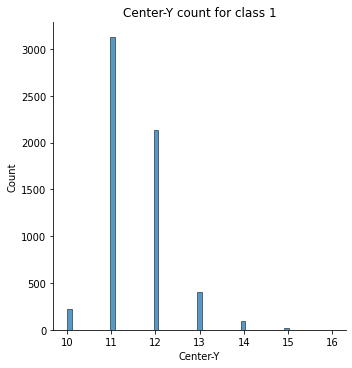

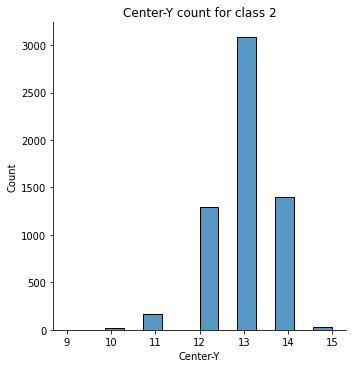

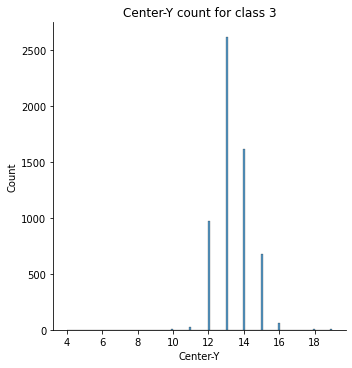

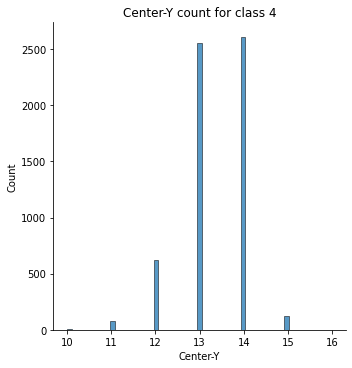

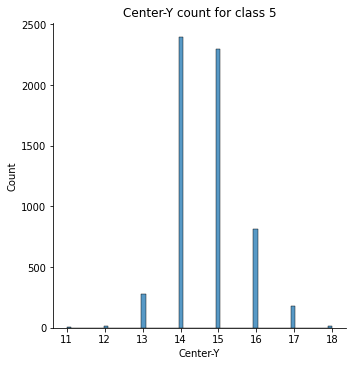

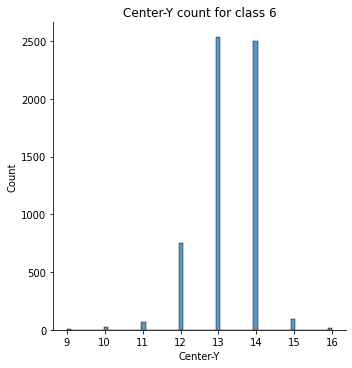

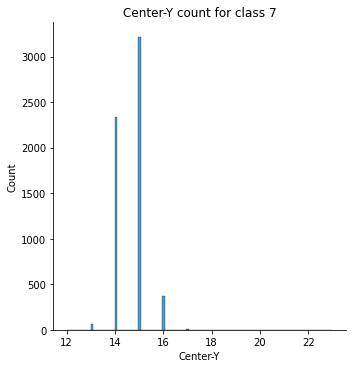

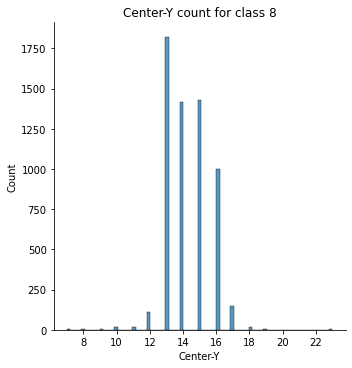

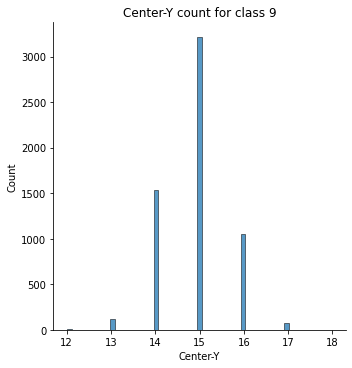

In [16]:
# クラス別の輪郭重心(Y)カバレッジ
interval = 4
max_range = 28
for c in classes:
    cov = calc_cov(moment_df.query(f'ClassNo == {c}'), col_name='Center-Y', title=f'Center-Y count for class {c}', file_name=f'CenterYCountClass{c}.png', max_range=max_range, interval=interval)
    print(f'class:{c} cov:{cov}')

total cov:0.5185185185185185


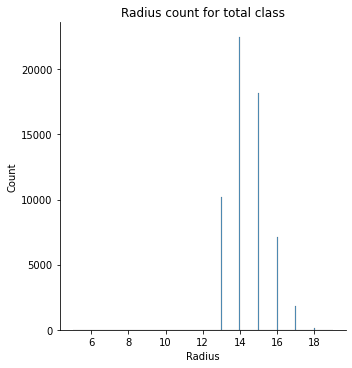

In [17]:
# トータルの最小外接円カバレッジ
interval = 9
max_range = 90  # 直径28pxの最大円周
cov = calc_cov(moment_df, col_name='Radius', title='Radius count for total class', file_name='RadiusCountTotalClass.png', max_range=max_range, interval=interval)
print(f'total cov:{cov}')

class:0 cov:0.5555555555555556
class:1 cov:0.3333333333333333
class:2 cov:0.3333333333333333
class:3 cov:0.5185185185185185
class:4 cov:0.3888888888888889
class:5 cov:0.3333333333333333
class:6 cov:0.3888888888888889
class:7 cov:0.5555555555555556
class:8 cov:0.48148148148148145
class:9 cov:0.2777777777777778


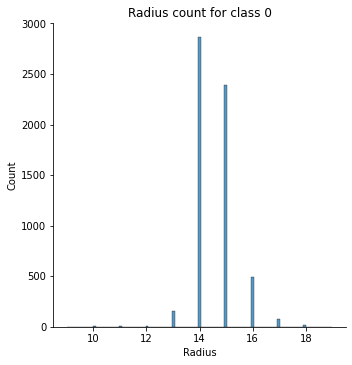

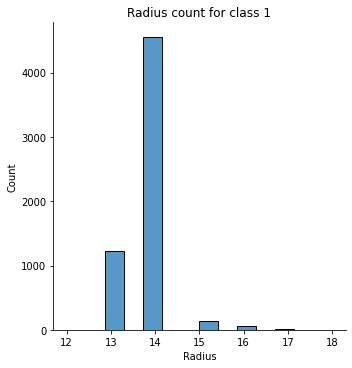

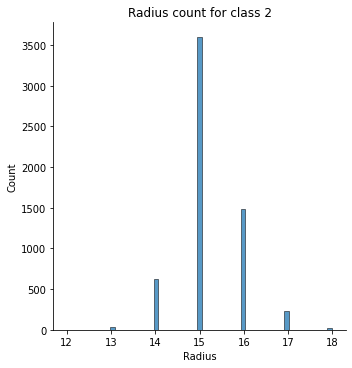

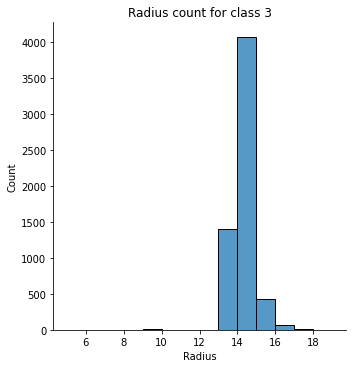

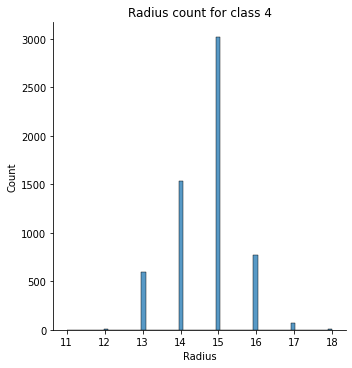

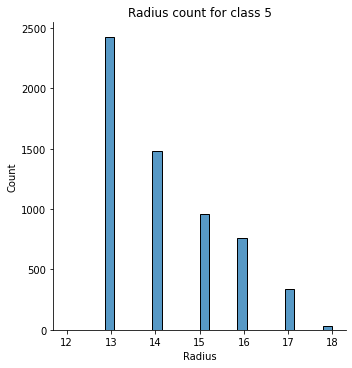

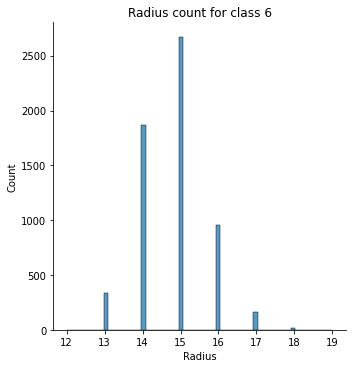

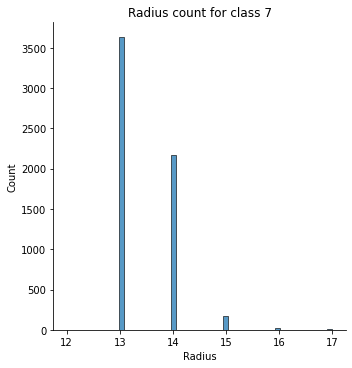

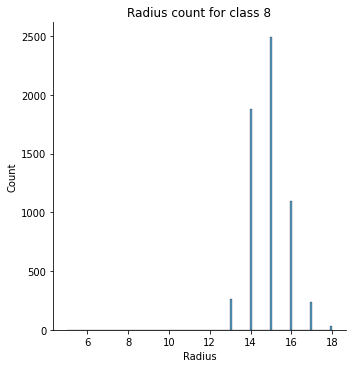

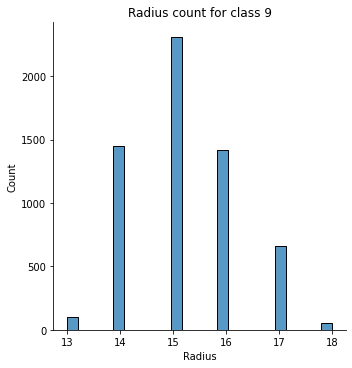

In [18]:
# クラス別の最小外接円カバレッジ
interval = 9
max_range = 90  # 直径28pxの最大円周
for c in classes:
    cov = calc_cov(moment_df.query(f'ClassNo == {c}'), col_name='Radius', title=f'Radius count for class {c}', file_name=f'RadiusCountClass{c}.png', max_range=max_range, interval=interval)
    print(f'class:{c} cov:{cov}')

In [19]:
# # トータルの傾きカバレッジ
# interval = 36
# max_range = 360
# cov = calc_cov(moment_df, col_name='Angle', title='Angle count for total class', file_name='AngleCountTotalClass.png', max_range=max_range, interval=interval)
# print(f'total cov:{cov}')

In [20]:
# # クラス別の傾きカバレッジ
# interval = 36
# max_range = 360
# for c in classes:
#     cov = calc_cov(moment_df.query(f'ClassNo == {c}'), col_name='Angle', title=f'Angle count for class {c}', file_name=f'AngleCountClass{c}.png', max_range=max_range, interval=interval)
#     print(f'class:{c} cov:{cov}')

In [21]:
# # トータルの2値化画素平均カバレッジ
# interval = 26
# max_range = 260
# cov = calc_cov(moment_df, col_name='Mean', title='Mean count for total class', file_name='MeanCountTotalClass.png', max_range=max_range, interval=interval)
# print(f'total cov:{cov}')

In [22]:
# # クラス別の2値化画素平均カバレッジ
# interval = 26
# max_range = 260
# for c in classes:
#     cov = calc_cov(moment_df.query(f'ClassNo == {c}'), col_name='Mean', title=f'Mean count for class {c}', file_name=f'MeanCountClass{c}.png', max_range=max_range, interval=interval)
#     print(f'class:{c} cov:{cov}')